In [1]:
import pandas as pd
import os
import sys

In [2]:
# function to merge "addition_df" into "base_df"
# based on "Date" and "Hour" columns
def merge_df_into(df1, df2):
    new_df = pd.merge(df1, df2, on=['Date', 'Hour'])

    # return
    return new_df


In [32]:
all  = pd.DataFrame()

dataset_names = [
    'B76-NO2.csv',
    'B76-Traffic.csv',
    'Timeflags.csv',
    'kiel_kronshagen_hourly_weather_2019.csv',
    'kiel_spritpreise_2019_hourly.csv',
    'kiel_vessel_data.csv'
]

dataset_hour_offsets = [ #Some datasets have hours 0-23, some have 1-24
    0,
    1,
    0,
    0,
    0,
    0
]

# check if all the files exists
for dataset_name in dataset_names:
    if not os.path.exists(dataset_name):
        print('File {} does not exist!'.format(dataset_name))
        sys.exit(1)

new_df = pd.DataFrame()
for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    if i > 0:
        #find offset
        hour_offset = dataset_hour_offsets[i]
        # read dataset
        additional_df = pd.read_csv(dataset_name)
        additional_df['Hour'] = additional_df['Hour'].astype(int) - hour_offset
        # merge into all
        new_df = merge_df_into(new_df, additional_df)
        print(dataset_name, 'merged... (', len(new_df), 'rows)')
    else:
        new_df = pd.read_csv(dataset_name)

#remove spritpreis_idx column
del new_df["spritpreis_idx"]
        
#fix no2
print("Fixing no2 column")
new_df["NO2-ug-per-m3"] = new_df["NO2-ug-per-m3"].astype(float)

#fix temperature
print("Fixing temperature column")
for idx, row in new_df.iterrows():    
    if row["air_temp_deg_c"] < -500:
        row["air_temp_deg_c"] = 0 #sensible values for nodata

        
# convert dates
print("Converting dates")
new_df["Hour"] = new_df["Hour"].astype("str")
new_df["DateTime"] = pd.to_datetime(new_df["Date"] + " " + new_df["Hour"] + ":00:00")
del new_df["Hour"]
del new_df["Date"]

# set datetime index
new_df.index = pd.DatetimeIndex(new_df.DateTime)
        
# add quadrature encoding for hours
import math
import calendar
from calendar import monthrange
print("Adding quadrature encoding")
for idx, row in new_df.iterrows():    
    new_df.loc[idx, "DaySin"] = math.sin(row["DateTime"].hour / 24.0 * math.pi * 2)
    new_df.loc[idx, "DayCos"] = math.cos(row["DateTime"].hour / 24.0 * math.pi * 2)
    new_df.loc[idx, "WeekSin"] = math.sin(row["DateTime"].weekday() / 7.0 * math.pi * 2)
    new_df.loc[idx, "WeekCos"] = math.cos(row["DateTime"].weekday() / 7.0 * math.pi * 2)
    days_in_month = monthrange(row["DateTime"].year, row["DateTime"].month)[1]
    new_df.loc[idx, "MonthSin"] = math.sin(row["DateTime"].month / days_in_month * math.pi * 2)
    new_df.loc[idx, "MonthCos"] = math.cos(row["DateTime"].month / days_in_month * math.pi * 2)
    days_in_year = 366 if calendar.isleap(row["DateTime"].year) else 365
    new_df.loc[idx, "YearSin"] = math.sin(row["DateTime"].timetuple().tm_yday / days_in_year * math.pi * 2)
    new_df.loc[idx, "YearCos"] = math.cos(row["DateTime"].timetuple().tm_yday / days_in_year * math.pi * 2)
    
# save the merged dataset
new_df.to_csv("All.csv", index=False)
# print head
print("Dataset has", len(new_df), " rows")
new_df.head()


B76-Traffic.csv merged... ( 8080 rows)
Timeflags.csv merged... ( 8080 rows)
kiel_kronshagen_hourly_weather_2019.csv merged... ( 8052 rows)
kiel_spritpreise_2019_hourly.csv merged... ( 8052 rows)
kiel_vessel_data.csv merged... ( 8052 rows)
Fixing no2 column
Fixing temperature column
Converting dates
Adding quadrature encoding
Dataset has 8052  rows)


,NO2-ug-per-m3,Cars-Direction-1,Cars-Direction-2,Cars-Total,Day-Of-Week,Monday,Tuesday,Wednesday,Thursday,Friday,...,Number of vessels,DateTime,DaySin,DayCos,WeekSin,WeekCos,MonthSin,MonthCos,YearSin,YearCos
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,19.0,36,62,98,2,0,1,0,0,0,...,6,2019-01-01 00:00:00,0.000000,1.000000,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 01:00:00,11.0,109,112,221,2,0,1,0,0,0,...,4,2019-01-01 01:00:00,0.258819,0.965926,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 02:00:00,9.0,97,60,157,2,0,1,0,0,0,...,2,2019-01-01 02:00:00,0.500000,0.866025,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 03:00:00,7.0,60,44,104,2,0,1,0,0,0,...,4,2019-01-01 03:00:00,0.707107,0.707107,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 04:00:00,8.0,44,33,77,2,0,1,0,0,0,...,3,2019-01-01 04:00:00,0.866025,0.500000,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852


# Dataset time coverage

In [4]:
import datetime as dt

start_date = '2019-01-01'
end_date = '2019-12-31'

timelime = pd.DataFrame()

dataset_names.append('All.csv')

# iterate datatsets
for dataset_name in dataset_names:
    print(dataset_name, "...")

    # read dataset
    df = pd.read_csv(dataset_name)
    df = df.dropna()

    from_date = None

    cnt_total_hours = 0
    cnt_valid_hours = 0

    # iterate days from start_date to end_date
    for day in pd.date_range(start_date, end_date):
        # day into this format YYYY-MM-DD
        date_no_hours = day.strftime('%Y-%m-%d')

        # iterate 24 hours
        for hour in range(24):
            cnt_total_hours += 1

            date_time = date_no_hours + ' ' + str(hour) + ':00:00'

            # select data for current day and hour
            df_day_hour = df[(df['Date'] == date_no_hours)
                             & (df['Hour'] == hour)]

            # if data for current day and hour exists
            if df_day_hour.shape[0] == 1:
                cnt_valid_hours += 1
                
                if not from_date:
                    # clone date_cursor into from_date
                    from_date = ""+date_time
            else:
                
                if from_date:
                    # append row to timeline
                    timelime = timelime.append({
                        'from': from_date,
                        'to': date_time,
                        'dataset': dataset_name
                    }, ignore_index=True)
                    from_date = None
    if from_date is not None:
        # append row to timeline
        timelime = timelime.append({
            'from': from_date,
            'to': end_date + ' 23:00:00',
            'dataset': dataset_name
        }, ignore_index=True)

    print(dataset_name, "data coverage:", int((cnt_valid_hours / cnt_total_hours) * 100), "%")

timelime['from'] = timelime['from'].astype('datetime64[ns]')
timelime['to'] = timelime['to'].astype('datetime64[ns]')

timelime.head()


B76-NO2.csv ...
B76-NO2.csv data coverage: 92 %
B76-Traffic.csv ...
B76-Traffic.csv data coverage: 95 %
Timeflags.csv ...
Timeflags.csv data coverage: 100 %
kiel_kronshagen_hourly_weather_2019.csv ...
kiel_kronshagen_hourly_weather_2019.csv data coverage: 99 %
kiel_spritpreise_2019_hourly.csv ...
kiel_spritpreise_2019_hourly.csv data coverage: 82 %
kiel_vessel_data.csv ...
kiel_vessel_data.csv data coverage: 100 %
All.csv ...
All.csv data coverage: 74 %


,from,to,dataset
0,2019-01-01 00:00:00,2019-01-02 16:00:00,B76-NO2.csv
1,2019-01-02 20:00:00,2019-01-03 06:00:00,B76-NO2.csv
2,2019-01-03 16:00:00,2019-01-03 17:00:00,B76-NO2.csv
3,2019-01-03 19:00:00,2019-01-05 09:00:00,B76-NO2.csv
4,2019-01-05 10:00:00,2019-01-07 06:00:00,B76-NO2.csv


In [5]:
import altair as alt
alt.Chart(timelime).mark_bar().encode(
    x='from',
    x2='to',
    y='dataset',
    color=alt.Color('dataset', scale=alt.Scale(scheme='dark2'))
)


ModuleNotFoundError: No module named 'altair'

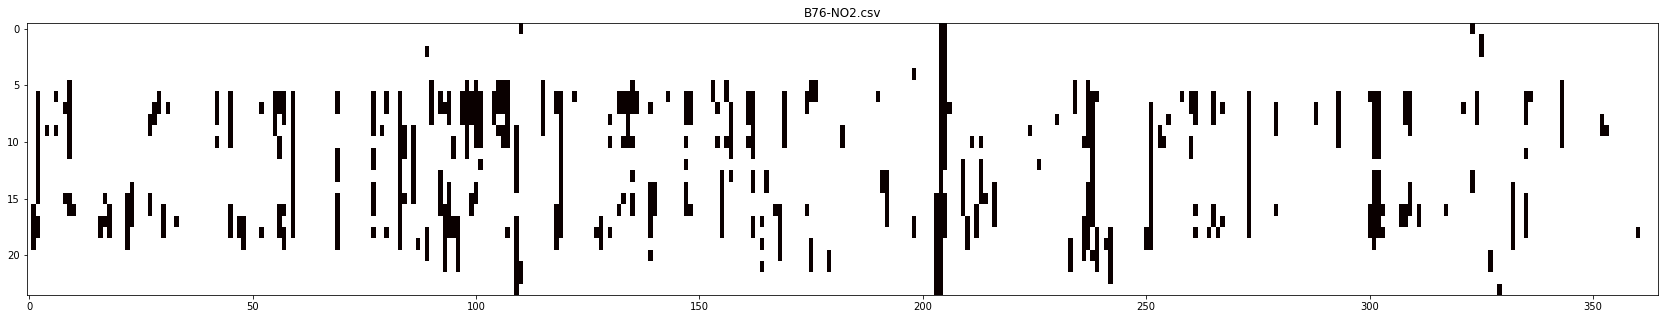

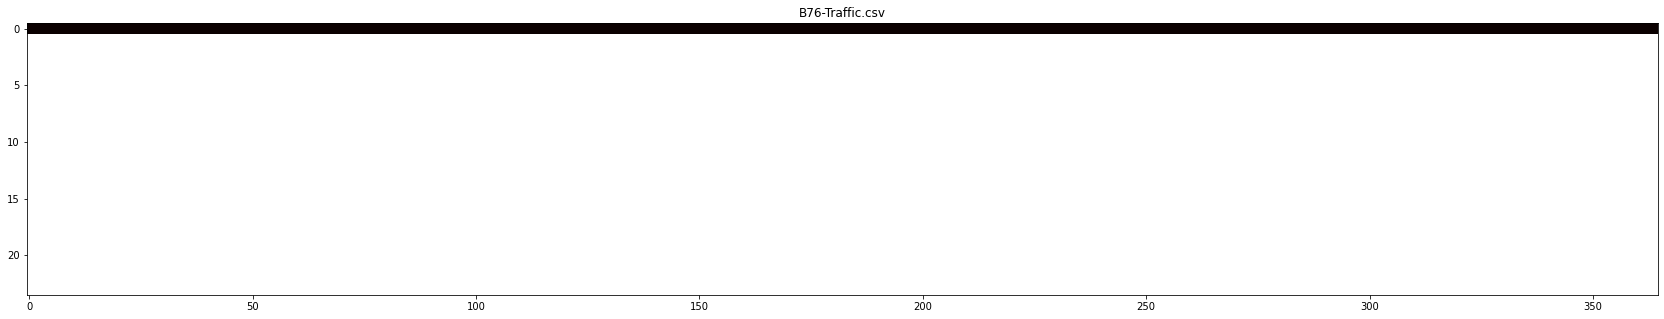

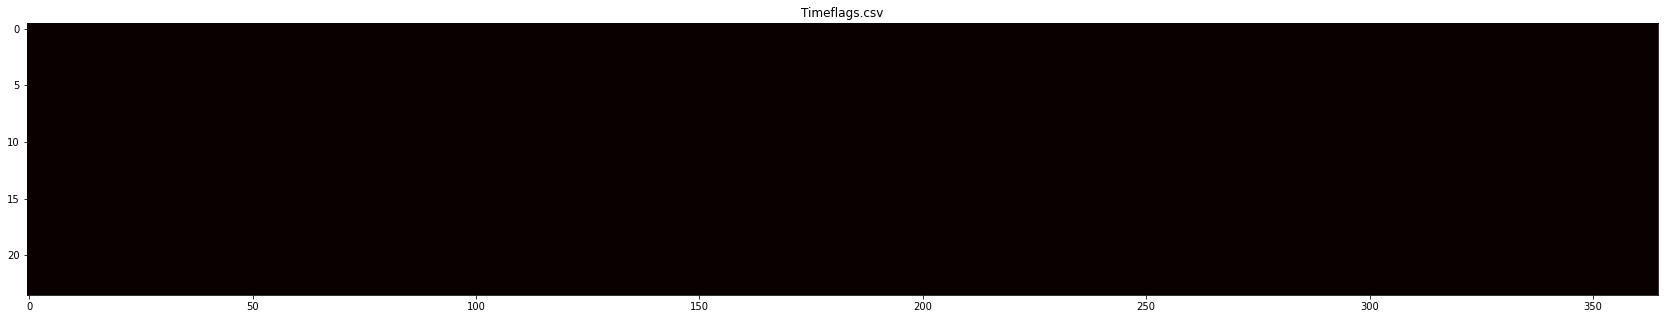

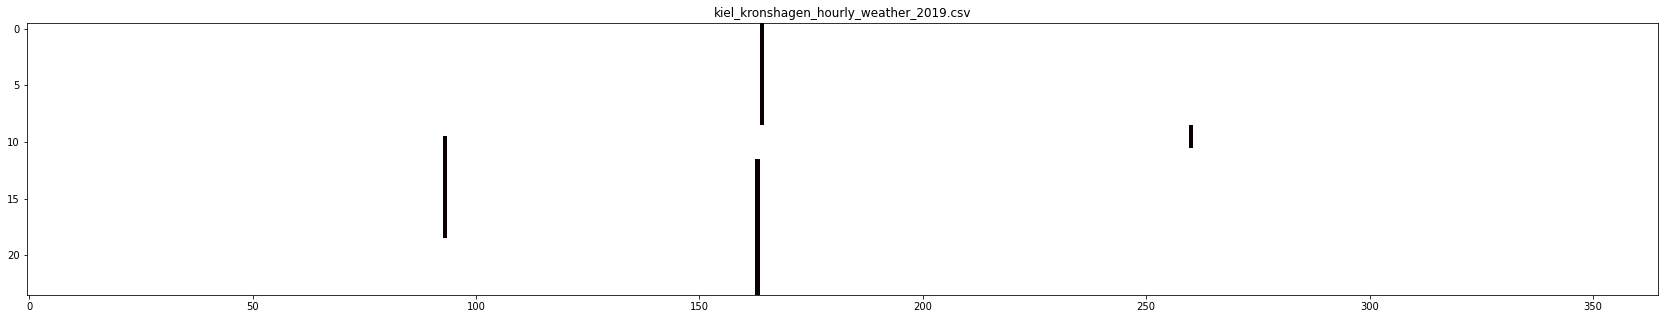

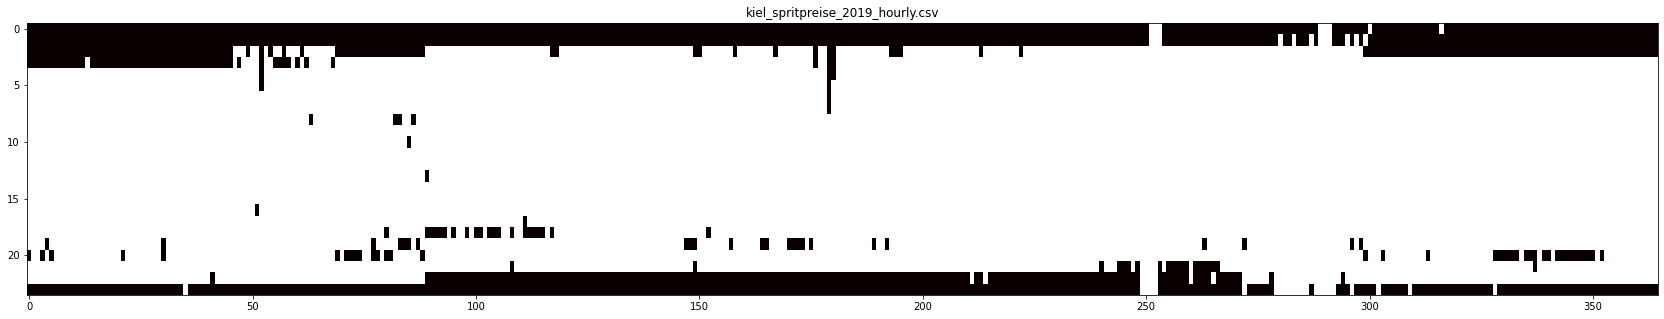

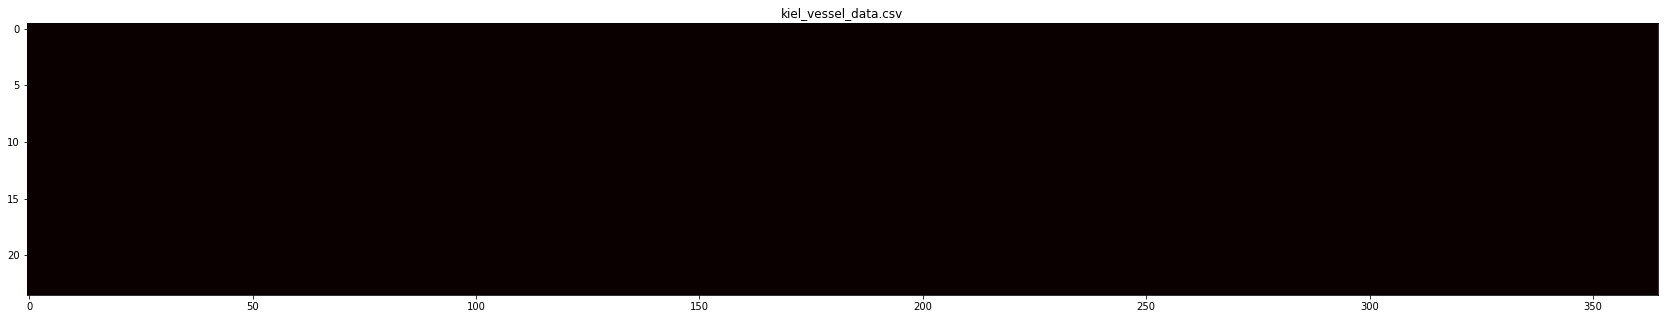

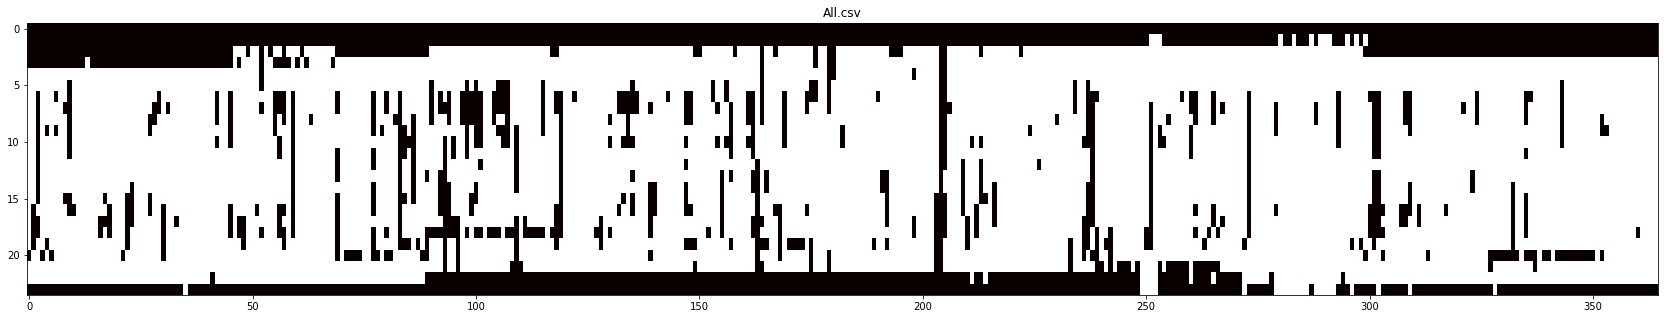

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def yearplot_dataset(dataset_name):
    # read dataset
    df = pd.read_csv(dataset_name)
    df = df.dropna()

    # array with 365 days on axis 0 and 24 hours on axis 1
    array = np.zeros((24, 365))
    # iterate array
    for i in range(24):
        for j in range(365):
            # select data for current day and hour
            # get datetime by day of the year
            date = (dt.datetime(2019, 1, 1) +
                         dt.timedelta(days=j))   .strftime('%Y-%m-%d')


            # read datas# get row by date and hour
            row = df[(df['Date'] == date) & (df['Hour'] == i)]

            # if data for current day and hour exists
            if row.shape[0] != 0:
                # set value to 1
                array[i, j] = 1
            else:
                # set value to 0
                array[i, j] = 0

    # plot matrix as square heatmap
    plt.figure(figsize=(60, 5))
    plt.imshow(array, cmap="hot", interpolation="nearest",
               aspect=(365/24)/6)
    #title 
    plt.title(dataset_name)

    plt.show()

# iterate datasets
for dataset_name in dataset_names:
    yearplot_dataset(dataset_name)


   
